<div>
<img src="figures/svtLogo.png"/>
</div>
<h1><center>Mathematical Optimization for Engineers</center></h1>
<h2><center>Lab 11 - Full discretization method</center></h2>

$\newcommand{\ddt}[1]{\frac{d#1}{dt}\Bigr \rvert_{t}}$
In this exercise, we want to solve the van der Pol oscillator optimal control problem using the full discretization approach. 
The problem with state constraint is as follows: 


$\begin{align}
\min_{x(\cdot), u(\cdot)} \int_{t_{0}}^{t_{f}} x_1^2(t) &+ x_2^{2}(t) + u(t)^2 dt\\
s.t.  \ddt{x_1} &= (1-(x_2(t))^2)\cdot x_1(t) - x_2(t) + u(t),\quad t\in [t_0,t_f], \label{eq:vdp_b} \\
\ddt{x_2}&= x_1(t),\quad t\in [t_0,t_f] \label{eq:vdp_a} \\
\ddt{x_3} &= ({x_1}(t))^2 + ({x_2}(t))^2+ (u(t))^2 \quad t\in [t_0,t_f] \\
\mathbf{x}(t_{0}) &= \left[0.0, 1.0, 0.0 \right]^{T} \\
x_1(t) &\geq - 0.4 \quad \forall t \in [t_{0},t_{f}]\\
-0.3 &\leq u(t) \leq 1.0 \quad \forall t \in [t_{0},t_{f}]\\
\end{align}
$


Note that the objective function value can be determined from the value of the state $x_{3}$ and that $t_{f}=5$.


For the full discretization approach, the differential equations are discretized usually by implicit Runge-Kutta methods. In this exercise, we will use the implicit Euler method due to its simplicity.



### Imports

In [1]:
import numpy as np

from scipy.optimize import minimize
from scipy.optimize import Bounds
from scipy.optimize import NonlinearConstraint

from matplotlib import pyplot as plt

### Right-hand side function of ODE

In [109]:
def eval_rhs(x, u):
    f = np.array([
        (1-x[1]**2)*x[0] - x[1] + u[0],
        x[0],
        x[0]**2 + x[1]**2 + u[0]**2
    ])
    
    return f

### Constraints for optimization - discretized ODE

In [111]:
def cons(y, x0, finalTime, M, n_u):
    # time step h (equidistant here)
    h = finalTime / M
    # number of states n_x
    n_x = len(x0)
    ceq = np.zeros((M, n_x))

    # backward Euler y_(k+1) = y_(k) + h.f(t_(k+1),y_(k+1))
    y_ = np.reshape(y, (M,n_x+n_u))
    
    # evalue RHS first time step f1
    f1 = eval_rhs(y_[0,:n_x], y_[0,n_x:n_x+n_u])
    
    # first element of constraint ceq[0:n_x]
    ceq[0,:] = x0 + h * f1 - y_[0,:n_x]
        
    # int(z) for z in [] just converts all elements in the list to integer
    # it's an implementation detail because python only allows integer indices
    
    # second time step onward
    for k in np.arange(1,M):
        fk = eval_rhs(y_[k,:n_x],y_[k,n_x:n_x+n_u])
        
        ceq[k] = y_[k-1,:n_x] + h * fk - y_[k,:n_x]
            
    return ceq.flatten()

### Objective

In [114]:
def objective(y, x0):
    # define objective
    obj = y[-2]
    return obj

### Setting up optimization problem and solve it

In [116]:
n_x = 3 # dimension of state vector x 
n_u = 1 # dimension of control vector u

M=50 # Number of discretization intervals

x1_0 = 0 # initial value of x1
x2_0 = 1 # initial value of x2
x3_0 = 0 # initial value of x3

x_initial = [0.0, 1.0, 0.0]
finalTime = 5 # final time

x1_min = -0.4
u_min = -0.3
u_max = 1.0


n = (n_x+n_u)*M # number of optimization variables
iu = (np.arange(n_x,n,n_x+n_u)).astype(int) # indices of control variables
ix1 = [int(z)-3 for z in iu] # indices of state x1
ix2 = [int(z)-2 for z in iu] # indices of state x2
ix3 = [int(z)-1 for z in iu] # indices of state x3

lb = -float("inf")*np.ones(n) # initialize lower bounds on all variables
ub = float("inf")*np.ones(n) # initialize upper bounds on all variables

lb[iu] = u_min # lower bound of control 
ub[iu] = u_max # upper bound of control
lb[ix1] = x1_min # lower bound on x1

x_guess = np.zeros(n)  # initial guess of optimzation variable

x_guess[ix1] = x1_0  # initial guess for state x1
x_guess[ix2] = x2_0  # initial guess for state x2
x_guess[ix3] = x3_0  # initial guess for state x3

x_guess[iu] = 0.0  # initial guess for control u

bounds = Bounds(lb, ub)

consWithInitial = lambda y: cons(y, x_initial, finalTime, M, n_u)

nonlinear_constraints = NonlinearConstraint(consWithInitial, 0, 0)
# call optimization with bounds, constraints and objective
res = minimize(objective, x_guess, args=(x_initial), bounds = bounds, method='SLSQP', constraints=[nonlinear_constraints],
               options={"maxiter": 10000, 'iprint': 2, 'disp': True})

print('Optimal function value is')
print(res.fun)

  NIT    FC           OBJFUN            GNORM
    1   202    -1.108719E-01     1.000000E+00
    2   403     6.320982E-01     1.000000E+00
    3   604     2.714853E+00     1.000000E+00
    4   805     2.981548E+00     1.000000E+00
    5  1006     2.955657E+00     1.000000E+00
    6  1207     2.820939E+00     1.000000E+00
    7  1408     2.771703E+00     1.000000E+00
    8  1609     2.800691E+00     1.000000E+00
    9  1810     2.768467E+00     1.000000E+00
   10  2011     2.758840E+00     1.000000E+00
   11  2212     2.764718E+00     1.000000E+00
   12  2413     2.759293E+00     1.000000E+00
   13  2614     2.755296E+00     1.000000E+00
   14  2815     2.756104E+00     1.000000E+00
   15  3016     2.755835E+00     1.000000E+00
   16  3217     2.755881E+00     1.000000E+00
   17  3418     2.755706E+00     1.000000E+00
   18  3619     2.755752E+00     1.000000E+00
   19  3820     2.755763E+00     1.000000E+00
   20  4021     2.755764E+00     1.000000E+00
   21  4221     2.755764E+00     1

### Plot trajectories

/tmp/ipykernel_50/3352550625.py:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(311)
/tmp/ipykernel_50/3352550625.py:13: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(221)


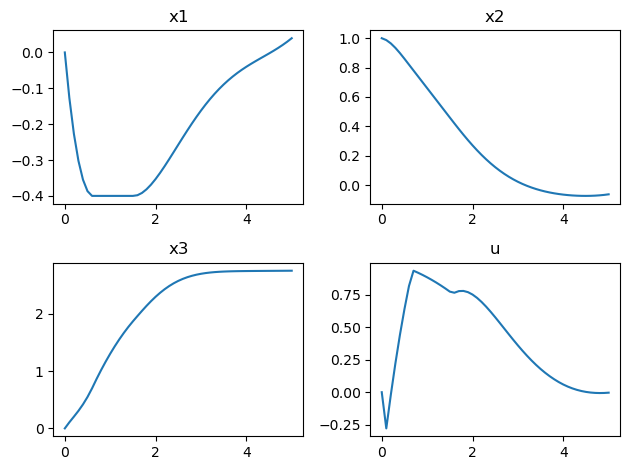

In [117]:
xopt = res.x

t = np.linspace(0, finalTime, M+1)
x1 = np.append([x1_0],list(xopt[np.arange(0,len(xopt),4)]))
x2 = np.append([x2_0],list(xopt[np.arange(1,len(xopt),4)]))
x3 = np.append([x3_0],list(xopt[np.arange(2,len(xopt),4)]))
u = np.append([0.0],list(xopt[np.arange(3,len(xopt),4)]))

plt.figure()
ax1 = plt.axes(xlim=(-4,4), ylim=(-4, 4))
plt.subplot(311)

plt.subplot(221)
plt.plot(t, x1)
plt.title('x1')

plt.subplot(222)
plt.plot(t, x2)
plt.title('x2')

plt.subplot(223)
plt.plot(t, x3)
plt.title('x3')
#
plt.subplot(224)
plt.plot(t, u)
plt.title('u')

plt.tight_layout()

plt.show()
